In [1]:
%run ../../_setup.py

from netCDF4 import Dataset
import xarray

from scipy.interpolate import griddata
import numpy as np

import pygmt

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cmocean as cmo


In [2]:
def gmtColormap(cptf, name=None):
    """Read a GMT color map from an OPEN cpt file
    Parameters
    ----------
    cptf : open file or url handle
        path to .cpt file
    name : str, optional
        name for color map
        if not provided, the file name will be used
    """
    # generate cmap name
    if name is None:
#         name = '_'.join(os.path.basename(cptf.name).split('.')[:-1])
        filename = os.path.basename(os.path.join(cptf))
        name = os.path.splitext(filename)[0]
    
    f = open(cptf)
    
    # process file
    x = []
    r = []
    g = []
    b = []
    lastls = None
    for l in f.readlines():
        ls = l.split()

        # skip empty lines
        if not ls:
            continue

        # parse header info
        if ls[0] in ["#", b"#"]:
            if ls[-1] in ["HSV", b"HSV"]:
                colorModel = "HSV"
            else:
                colorModel = "RGB"
            continue

        # skip BFN info
        if ls[0] in ["B", b"B", "F", b"F", "N", b"N"]:
            continue

        # parse color vectors
        x.append(float(ls[0]))
        r.append(float(ls[1]))
        g.append(float(ls[2]))
        b.append(float(ls[3]))

        # save last row
        lastls = ls

    x.append(float(lastls[4]))
    r.append(float(lastls[5]))
    g.append(float(lastls[6]))
    b.append(float(lastls[7]))
    
    x = np.array(x)
    r = np.array(r)
    g = np.array(g)
    b = np.array(b)

    if colorModel == "HSV":
        for i in range(r.shape[0]):
            # convert HSV to RGB
            rr,gg,bb = colorsys.hsv_to_rgb(r[i]/360., g[i], b[i])
            r[i] = rr ; g[i] = gg ; b[i] = bb
    elif colorModel == "RGB":
        r /= 255.
        g /= 255.
        b /= 255.

    red = []
    blue = []
    green = []
    xNorm = (x - x[0])/(x[-1] - x[0])
    for i in range(len(x)):
        red.append([xNorm[i],r[i],r[i]])
        green.append([xNorm[i],g[i],g[i]])
        blue.append([xNorm[i],b[i],b[i]])

    # return colormap
    cdict = dict(red=red,green=green,blue=blue)
    return mcolors.LinearSegmentedColormap(name=name,segmentdata=cdict)

def export_cmap_to_cpt(cmap, vmin=0, vmax=1, N=255, filename="test.cpt",**kwargs):
    # create string for upper, lower colors
    b = np.array(kwargs.get("B", cmap(0.)))
    f = np.array(kwargs.get("F", cmap(1.)))
    na = np.array(kwargs.get("N", (0,0,0))).astype(float)
    ext = (np.c_[b[:3],f[:3],na[:3]].T * cmap.N).astype(int)
    extstr = "B {:3d} {:3d} {:3d}\nF {:3d} {:3d} {:3d}\nN {:3d} {:3d} {:3d}"
    ex = extstr.format(*list(ext.flatten()))
    #create colormap
    cols = (cmap(np.linspace(0.,1.,N))[:,:3]*cmap.N).astype(int)
    vals = np.linspace(vmin, vmax, N)
    arr = np.c_[vals[:-1],cols[:-1],vals[1:],cols[1:]]
    # save to file
    fmt = "%e %3d %3d %3d %e %3d %3d %3d"
    np.savetxt(filename, arr, fmt=fmt, 
               header="# COLOR_MODEL = RGB",
               footer = ex, comments="")


In [3]:
savefig = True

# Bathymetry (Smith and Sandwell, 1997)

In [4]:
input_file = os.path.join(datadir, 'external', 'bathymetry', 'gebco_2019', 'gebco_2019_n-45.0_s-60.0_w135.0_e160.0.nc')
bathy = xarray.open_dataset(input_file)

# boundaries
north = -52.4
west = 137
south = -48
east = 147

# dep = bathy.depth.sel(longitude=slice(west, east), latitude=slice(north, south))
dep = bathy.elevation.sel(lon=slice(west, east), lat=slice(north, south))
depths = np.linspace(-5000, 0, 11)


# Sea surface heights and derived variables
http://marine.copernicus.eu/services-portfolio/access-to-products/?option=com_csw&view=details&product_id=SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047


In [5]:
input_file = os.path.join(datadir, 'external', 'ssh', 'rep', 'rep_allsat_phy_l4_135_-60_160_-45_1998.nc')

# Select data over time of the voyage
ssh = xarray.open_dataset(input_file)
SSHvoyage = ssh.sel(time=slice('1998-03-10', '1998-03-28'))

# Mean Absolute Dynamic Topography (ADT) over time of voyage
voyagemeanadt = SSHvoyage.mean('time')['adt']

# Weekly mean ADT
weeks = np.unique(SSHvoyage.time.dt.week)
weekmeanadt = ssh.groupby('time.week').mean('time')['adt'][weeks-1]


# CTD stations SS9802 and SR3 stations AA9802

In [6]:
input_file = os.path.join(datadir, 'ss9802', 'processed', 'ctd', 'ss9802_ctd.nc')
ctd = Dataset(input_file)

input_file = os.path.join(datadir, 'au9706', 'processed', 'au9706_ctd.nc')
sr3 = Dataset(input_file)

In [7]:
stations = [2, 18, 19, 21, 23, 40, 41, 44, 46, 67, 66, 65, 53, 73]
istations = [i for i, station in enumerate(sr3['station'][:]) if station in stations]


# Orsi et al. 1995 fronts

In [8]:
orsi = {}
fronts = {'stf': 'tomato', 'saf': 'skyblue', 'pf': 'royalblue'}
for front in fronts.keys():
    input_file = os.path.join(datadir, 'external', 'orsi', front + '.txt')
    lon, lat = zip(*np.genfromtxt(input_file, delimiter='   ', comments='%'))
    orsi[front] = [lon, lat]


In [9]:
Nin = 256
Nout = 6
    
cmap = plt.get_cmap(cmo.cm.deep_r, cmo.cm.deep_r.N)
export_cmap_to_cpt(cmap, vmin=-5000, vmax=-1000, N=Nout, filename="../cmaps/cmocean_deep.cpt")

In [10]:
odds = [1, 2, 9, 10, 11, 12, 27, 45, 46, 47, 75, 76, 77, 78, 101]
iodds = [istat for istat, station in enumerate(ctd['station']) if station in odds]

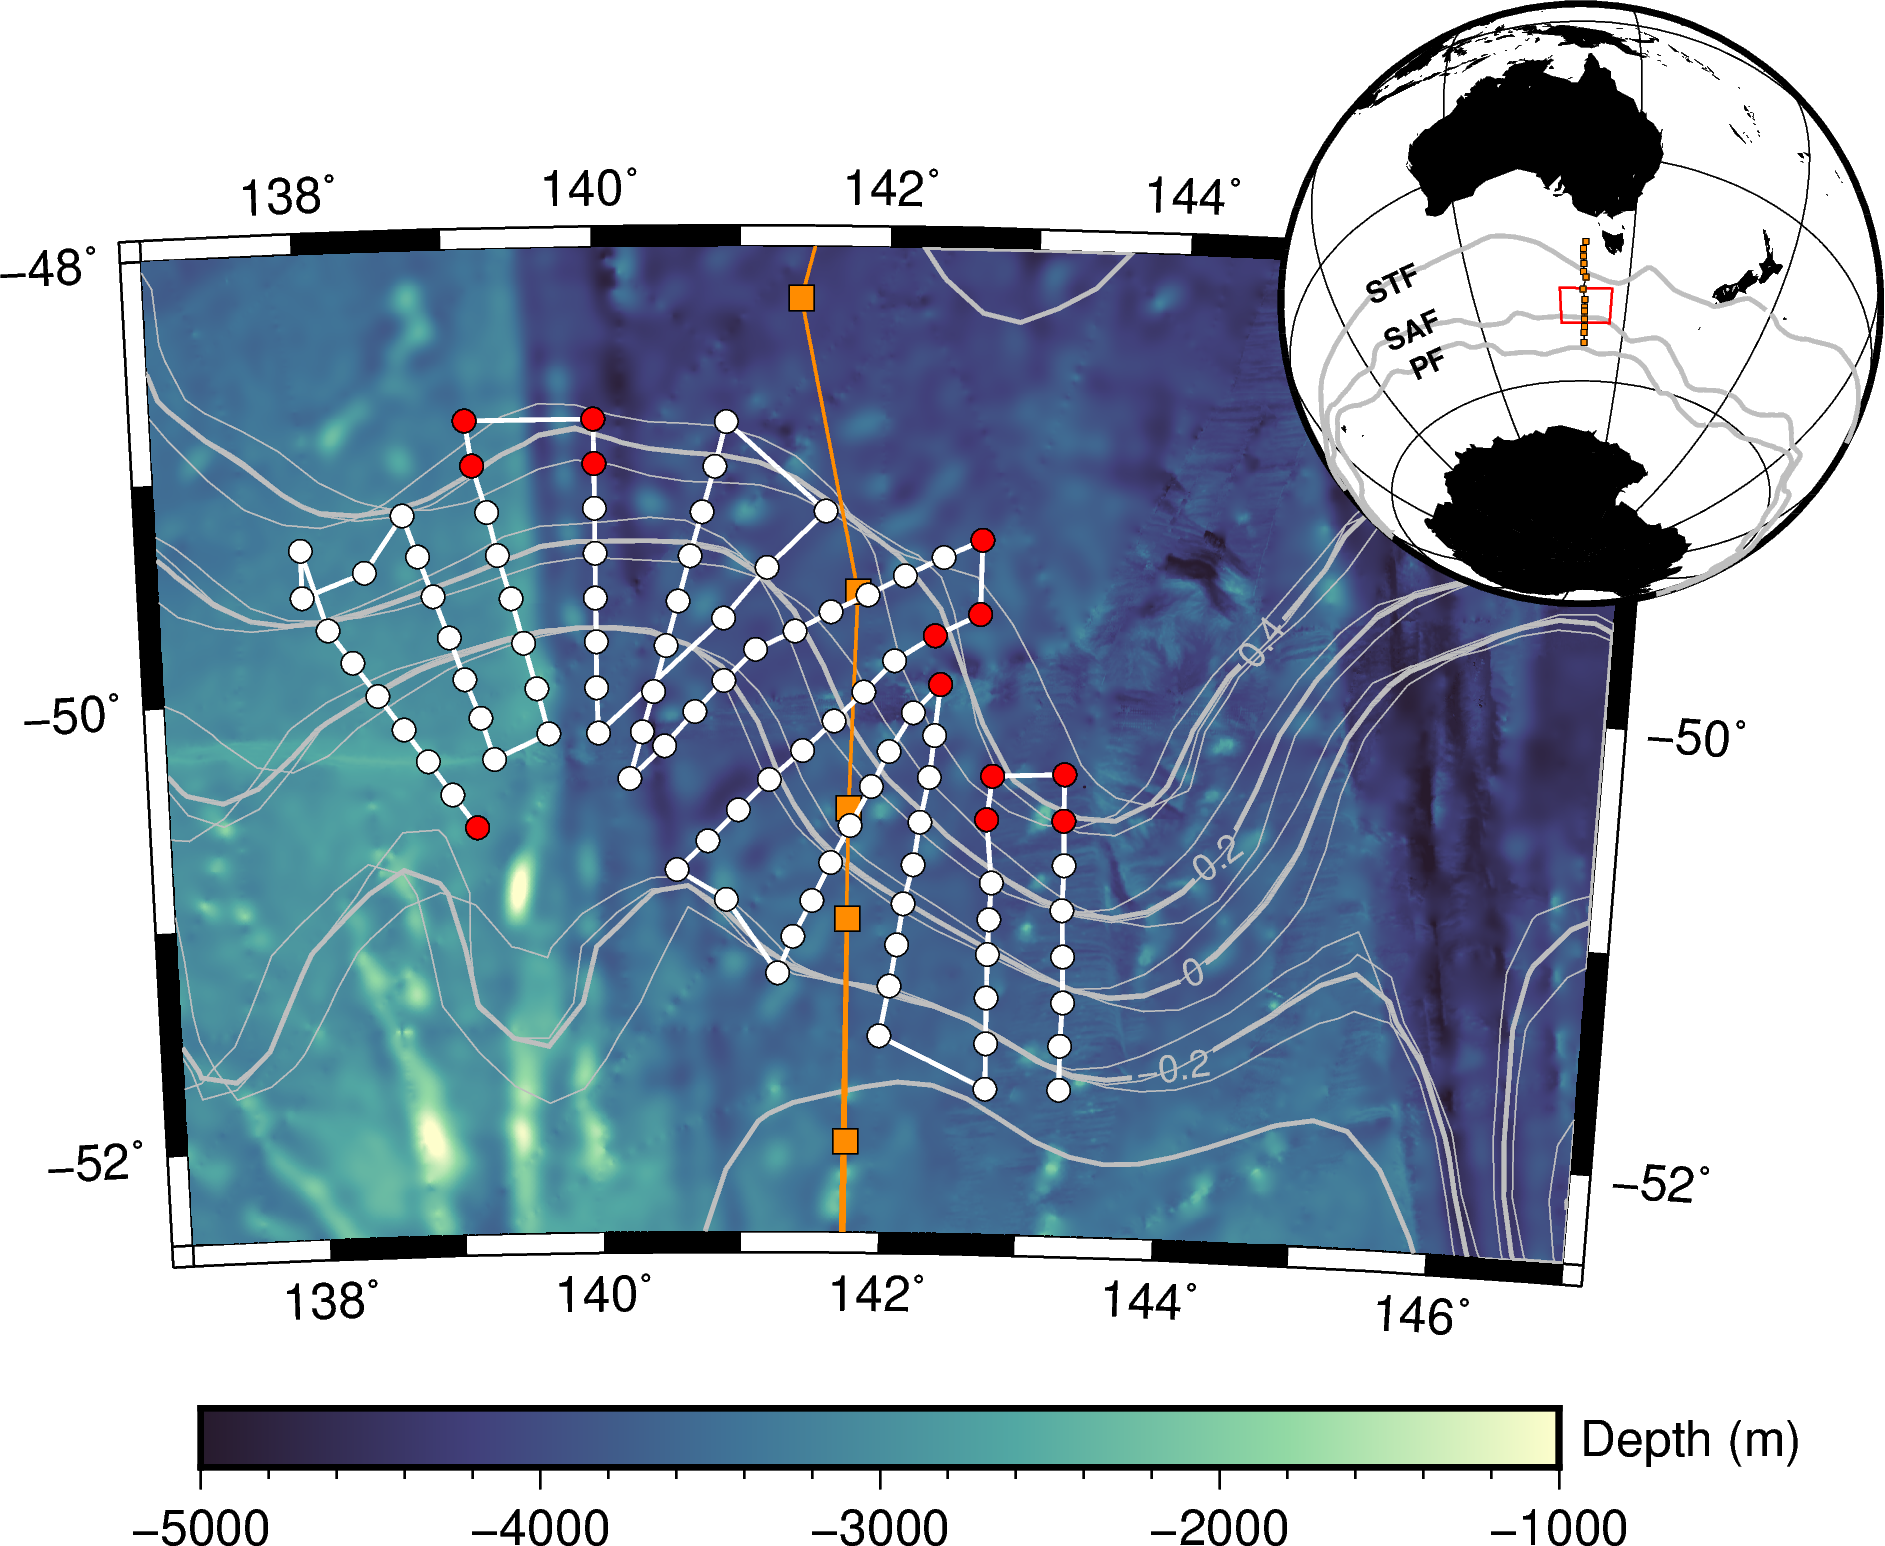

In [11]:
fig = pygmt.Figure()
fig.coast(region=[137, 147, -52.4, -48], projection='B141/-51/-50/-49/5i', land='black', water='skyblue', frame=True)

# -DJRM+o0.6i/0+mc -I0.3 -Bx2+lTOPO -By+lkm
# plot bathymetry
fig.grdimage(dep, projection='B141/-51/-50/-49/5i', region=[137, 147, -52.4, -48], cmap='../cmaps/cmocean_deep.cpt')#, shading='+a120+nt1.5')
fig.colorbar(
    cmap="../cmaps/cmocean_deep.cpt",
    position="n0.04/-0.2+w11.5/0.5+h",  # plot using paper coordinates (x) at 1.2cm,4.75cm
    frame=["xaf", "y+lDepth\t(m)"], #-DJRM+o0.6i/0+e+mc
    scale=1,
)
# plot SSH contours
for i in range(weekmeanadt.shape[0]):
    fig.grdcontour(weekmeanadt[i], interval=0.2, annotation='-', limit=[-0.3, 0.5], pen='gray')
fig.grdcontour(voyagemeanadt, interval=0.2, annotation=0.2, label_placement='l144/52S/145/48S', limit=[-0.4, 0.7], pen='1p,gray')

# plot AU9706 stations and shiptrack
fig.plot(x=sr3['longitude'][istations], y=sr3['latitude'][istations], pen='0.7p,darkorange')
fig.plot(x=sr3['longitude'][istations], y=sr3['latitude'][istations], style='s0.3c', color='darkorange', pen='black')

# plot SS9802 stations and shiptrack
fig.plot(x=ctd['lon'][2:,0], y=ctd['lat'][2:,0], pen='1p,white')
fig.plot(x=ctd['lon'][2:,0], y=ctd['lat'][2:,0], style='c0.2c', color='white', pen='black')
fig.plot(x=ctd['lon'][iodds,0], y=ctd['lat'][iodds,0], style='c0.2c', color='red', pen='black')

# plot globe subplot and mean SSH contours of fronts from Orsi et al. 1995
fig.coast(region="g", projection="G141/-50.1/10000/0/0/0/0/0/2i", land="black", water='white', frame='afg', X='3.8i', Y='2.2i')
for front in fronts.keys():
    fig.plot(orsi[front][0], orsi[front][1], pen='1p,gray') #'0.75p,%s' %fronts[front]
#     fig.plot([140, 150], [-50, -52], text='5p'+'hello')

# plot SS9802 survey area in subplot
fig.plot([137.0, 147.0, 147.0, 137.0, 137.0], [-52.4, -52.4, -48.0, -48.0, -52.4], pen='0.5p,red')
fig.plot(x=sr3['longitude'][istations], y=sr3['latitude'][istations], pen='0.2p,black')
fig.plot(x=sr3['longitude'][istations], y=sr3['latitude'][istations], style='s0.07c', color='darkorange', pen='0.1p,black')

fig.text(x=105, y=-53, angle=25,text='PF',font='7p,Helvetica-Bold,black')
fig.text(x=105, y=-48, angle=25,text='SAF',font='7p,Helvetica-Bold,black')
fig.text(x=105, y=-41, angle=25,text='STF',font='7p,Helvetica-Bold,black')

fig.show(dpi=300, width=1000)

In [12]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        transparent = True if extension == '.png' else False
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', '01_overview-map' + extension), transparent=transparent)